## ST-590
## Final Project

In [68]:
import pandas as pd
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import pyspark.pandas as ps
from pyspark.sql import SparkSession

from pyspark.ml.feature import SQLTransformer
from pyspark.ml.feature import VectorAssembler

spark = SparkSession.builder.getOrCreate()


data = pd.read_csv("data/diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [69]:
diabetes = spark.createDataFrame(data)
diabetes.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|     0.35100000000000003| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|     0.16699999999999998| 21|      0|
|          0|    137|           40|           35|    168|43.1|      2.2880000000000003| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



In [70]:
train, test = diabetes.randomSplit([0.8,0.2], seed = 1)
print(train.count(), test.count())

607 161


In [71]:
train.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          0|    100|           88|           60|    110|46.8|      0.9620000000000001| 31|      0|
|          0|    101|           65|           28|      0|24.6|                   0.237| 22|      0|
|          0|    105|           64|           41|    142|41.5|     0.17300000000000001| 22|      0|
|          0|    109|           88|           30|      0|32.5|                   0.855| 38|      1|
|          0|    131|            0|            0|      0|43.2|                    0.27| 26|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



### EDA

In [313]:
train.select('Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness' ).describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|       Pregnancies|           Glucose|     BloodPressure|     SkinThickness|
+-------+------------------+------------------+------------------+------------------+
|  count|               607|               607|               607|               607|
|   mean|3.7891268533772653|119.36738056013179| 69.08072487644152|20.191103789126853|
| stddev| 3.322840308863052|31.996263038169634|19.905430063385733|15.679958827932095|
|    min|                 0|                 0|                 0|                 0|
|    max|                15|               199|               122|                63|
+-------+------------------+------------------+------------------+------------------+



In [314]:
train.select('Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age' ).describe().show()

+-------+-----------------+------------------+------------------------+------------------+
|summary|          Insulin|               BMI|DiabetesPedigreeFunction|               Age|
+-------+-----------------+------------------+------------------------+------------------+
|  count|              607|               607|                     607|               607|
|   mean| 75.0313014827018|31.966062602965405|      0.4653492586490939| 33.27347611202636|
| stddev|110.6757998930512| 8.105643318900489|     0.32853833196886145|11.871187278518361|
|    min|                0|               0.0|                   0.085|                21|
|    max|              846|              67.1|                    2.42|                81|
+-------+-----------------+------------------+------------------------+------------------+



In [315]:
train.groupby('Outcome').count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      0|  401|
|      1|  206|
+-------+-----+



In [316]:
import pyspark.sql.functions as f
# checking for null values in each column
data_agg = train.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in train.columns])
data_agg.show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



In [323]:
train.select('BloodPressure').where(train.BloodPressure == '0').count()

30

In [322]:
train.select('Glucose').where(train.Glucose == '0').count()

5

In [324]:
train.select('BMI').where(train.BMI == '0').count()

10

In [325]:
train.select('Insulin').where(train.Insulin == '0').count()

301

In [311]:

expl_vars = ['BloodPressure', 'Pregnancies', 'Glucose', 'SkinThickness', 'Insulin',
            'DiabetesPedigreeFunction', 'Age']

min_values = train.groupBy('Outcome').agg({var: 'min' for var in expl_vars})
min_values.show()

avg = train.groupBy('Outcome').agg({var: 'avg' for var in expl_vars})
avg.show()

max_values = train.groupBy('Outcome').agg({var: 'max' for var in expl_vars})
max_values.show()

+-------+----------------+------------+-----------------------------+------------------+--------+------------------+------------+
|Outcome|min(Pregnancies)|min(Insulin)|min(DiabetesPedigreeFunction)|min(SkinThickness)|min(Age)|min(BloodPressure)|min(Glucose)|
+-------+----------------+------------+-----------------------------+------------------+--------+------------------+------------+
|      0|               0|           0|                        0.085|                 0|      21|                 0|           0|
|      1|               0|           0|          0.08800000000000001|                 0|      21|                 0|           0|
+-------+----------------+------------+-----------------------------+------------------+--------+------------------+------------+

+-------+-----------------+-----------------+-----------------------------+------------------+----------------+------------------+------------------+
|Outcome| avg(Pregnancies)|     avg(Insulin)|avg(DiabetesPedigreeFunc

<AxesSubplot:title={'center':'Blood pressure vs glucose'}, xlabel='Pregnancies', ylabel='BloodPressure'>

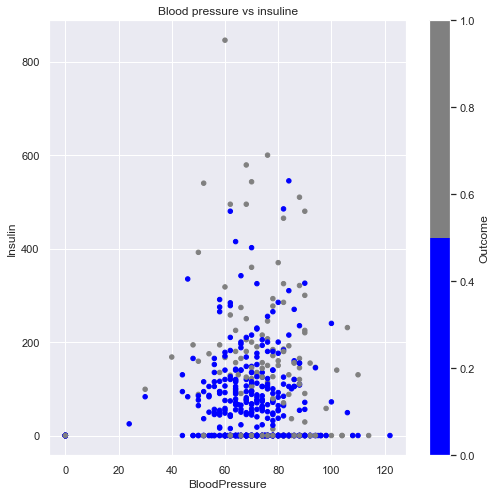

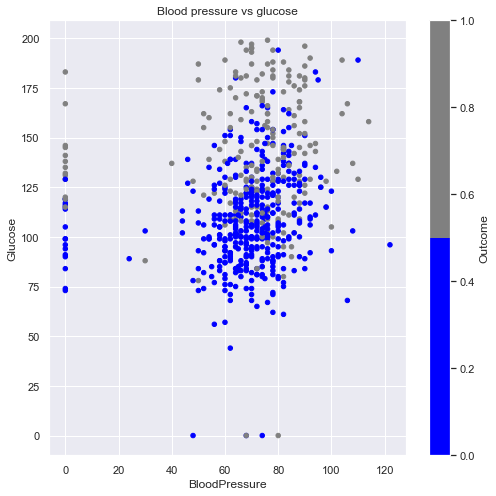

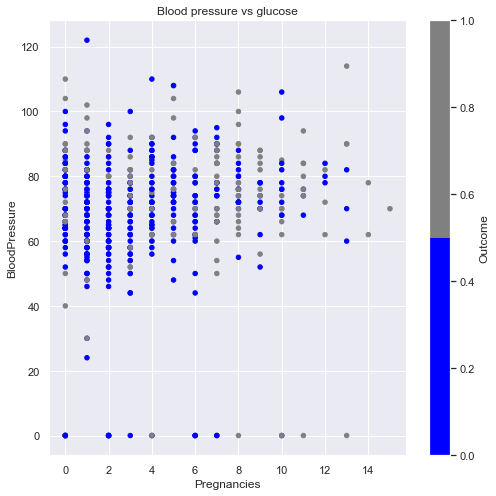

In [278]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
ps.options.plotting.backend = 'matplotlib'

mycmap = colors.ListedColormap(['blue', 'grey'])
eda_train = train.to_pandas_on_spark()
#eda_train.plot.scatter(x='BloodPressure', y='Insulin')
eda_train.plot.scatter(x='BloodPressure', y='Insulin', c = 'Outcome', colormap = mycmap, 
                       ylabel = "Insulin level", 
                       xlabel = "Blood pressure",
                       title = "Blood pressure vs insuline",
                       sharex = False,
                       figsize = (8, 8))

eda_train.plot.scatter(x='BloodPressure', y='Glucose', c = 'Outcome', colormap = mycmap, #colormap = "tab10",
                       ylabel = "Glucose", 
                       xlabel = "Blood pressure",
                       title = "Blood pressure vs glucose",
                       sharex = False,
                       figsize = (8, 8))

eda_train.plot.scatter(x='Pregnancies', y='BloodPressure', c = 'Outcome', colormap = mycmap, #colormap = "tab10",
                       ylabel = "BloodPressure", 
                       xlabel = "# of Pregnancies",
                       title = "Blood pressure vs glucose",
                       sharex = False,
                       figsize = (8, 8))

In [135]:
eda_train[['BloodPressure', 'Pregnancies', 'Glucose', 'SkinThickness', 'Insulin','DiabetesPedigreeFunction', 'Age']].corr()

/opt/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


,BloodPressure,Pregnancies,Glucose,SkinThickness,Insulin,DiabetesPedigreeFunction,Age
BloodPressure,1.000000,0.120236,0.149621,0.225103,0.088609,0.044674,0.240461
Pregnancies,0.120236,1.000000,0.125612,-0.096489,-0.061967,-0.066191,0.540907
Glucose,0.149621,0.125612,1.000000,0.045829,0.295180,0.107185,0.261922
SkinThickness,0.225103,-0.096489,0.045829,1.000000,0.449423,0.176543,-0.128871
Insulin,0.088609,-0.061967,0.295180,0.449423,1.000000,0.137497,-0.017874
DiabetesPedigreeFunction,0.044674,-0.066191,0.107185,0.176543,0.137497,1.000000,0.022669
Age,0.240461,0.540907,0.261922,-0.128871,-0.017874,0.022669,1.000000


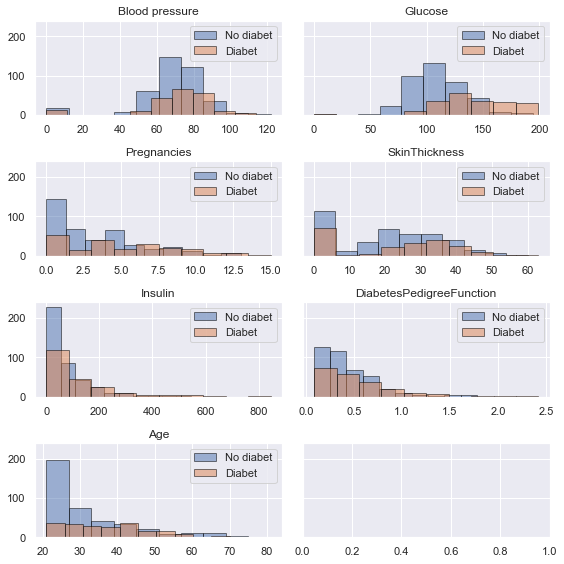

In [279]:

#fig, axs = plt.subplots()
#fig.suptitle("Blood pressure", fontsize=16)
#axs.hist(eda_train.loc[eda_train.Outcome == "0", ["BloodPressure"]].BloodPressure,  alpha = 0.5, ec="black", label="No diabet")
#axs.hist(eda_train.loc[eda_train.Outcome == "1", ["BloodPressure"]].BloodPressure,  alpha = 0.5, ec="black", label = "Diabet")
#axs.legend()



fig, axs = plt.subplots(4, 2, sharey=True, tight_layout=True, figsize = (8, 8))
#fig.suptitle("Blood pressure", fontsize=16)
axs[0,0].hist(eda_train.loc[eda_train.Outcome == "0", ["BloodPressure"]].BloodPressure,  alpha = 0.5, ec="black", label="No diabet")
axs[0,0].hist(eda_train.loc[eda_train.Outcome == "1", ["BloodPressure"]].BloodPressure,  alpha = 0.5, ec="black", label = "Diabet")
axs[0,0].set_title("Blood pressure")
axs[0,0].legend()


axs[0,1].hist(eda_train.loc[eda_train.Outcome == "0", ["Glucose"]].Glucose,  alpha = 0.5, ec="black", label="No diabet")
axs[0,1].hist(eda_train.loc[eda_train.Outcome == "1", ["Glucose"]].Glucose,  alpha = 0.5, ec="black", label = "Diabet")
axs[0,1].set_title("Glucose")
axs[0,1].legend()

axs[1,0].hist(eda_train.loc[eda_train.Outcome == "0", ["Pregnancies"]].Pregnancies,  alpha = 0.5, ec="black", label="No diabet")
axs[1,0].hist(eda_train.loc[eda_train.Outcome == "1", ["Pregnancies"]].Pregnancies,  alpha = 0.5, ec="black", label = "Diabet")
axs[1,0].set_title("Pregnancies")
axs[1,0].legend()


axs[1,1].hist(eda_train.loc[eda_train.Outcome == "0", ["SkinThickness"]].SkinThickness,  alpha = 0.5, ec="black", label="No diabet")
axs[1,1].hist(eda_train.loc[eda_train.Outcome == "1", ["SkinThickness"]].SkinThickness,  alpha = 0.5, ec="black", label = "Diabet")
axs[1,1].set_title("SkinThickness")
axs[1,1].legend()


axs[2,0].hist(eda_train.loc[eda_train.Outcome == "0", ["Insulin"]].Insulin,  alpha = 0.5, ec="black", label="No diabet")
axs[2,0].hist(eda_train.loc[eda_train.Outcome == "1", ["Insulin"]].Insulin,  alpha = 0.5, ec="black", label = "Diabet")
axs[2,0].set_title("Insulin")
axs[2,0].legend()

axs[2,1].hist(eda_train.loc[eda_train.Outcome == "0", ["DiabetesPedigreeFunction"]].DiabetesPedigreeFunction,  alpha = 0.5, ec="black", label="No diabet")
axs[2,1].hist(eda_train.loc[eda_train.Outcome == "1", ["DiabetesPedigreeFunction"]].DiabetesPedigreeFunction,  alpha = 0.5, ec="black", label = "Diabet")
axs[2,1].set_title("DiabetesPedigreeFunction")
axs[2,1].legend()


axs[3,0].hist(eda_train.loc[eda_train.Outcome == "0", ["Age"]].Age,  alpha = 0.5, ec="black", label="No diabet")
axs[3,0].hist(eda_train.loc[eda_train.Outcome == "1", ["Age"]].Age,  alpha = 0.5, ec="black", label = "Diabet")
axs[3,0].set_title("Age")
axs[3,0].legend()

#fig = plt.figure(figsize =(10, 7))
#ax = fig.add_axes([0, 0, 1, 1])
#bp = ax.boxplot(eda_train[['Outcome', 'BloodPressure']].groupby(['Outcome']))
#plt.show() 


#plt.boxplot(eda_train.loc[eda_train['Outcome'] == 0, 'BloodPressure'], eda_train.loc[eda_train['Outcome'] == 1, 'BloodPressure'] )
#plt.boxplot(eda_train.loc[df['Outcome'] == 0, 'BloodPressure'].item())

#eda_train.loc[eda_train['Outcome'] == 0, 'BloodPressure']

#eda_train[['Outcome', 'BloodPressure']].groupby(['Outcome']).plot(kind='box')

#eda_train[["BloodPressure", "Outcome"]].plot.box(
#        by = "Outcome",
#    ylabel = "Selling Price (in $1,000's)",
#    figsize = (8, 8)
#)

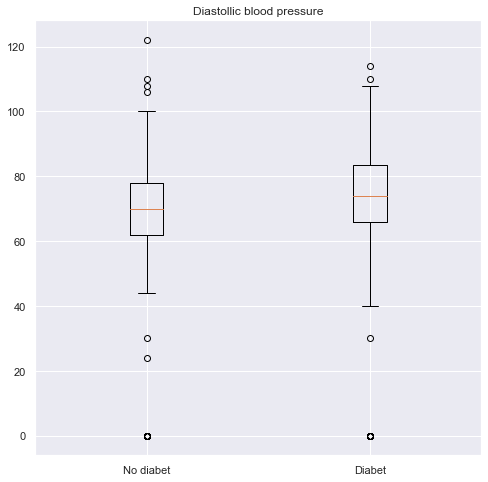

In [352]:
plt.rcParams['figure.figsize'] = [8, 8]
a = eda_train.loc[eda_train['Outcome'] == 0, 'BloodPressure']
b = eda_train.loc[eda_train['Outcome'] == 1, 'BloodPressure']

data = [a,b]

for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])

plt.xticks([0,1], ['No diabet','Diabet'])
plt.title ('Diastollic blood pressure')
plt.show()

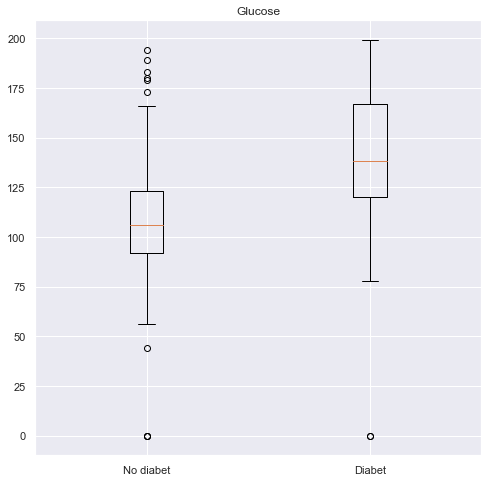

In [354]:
a = eda_train.loc[eda_train['Outcome'] == 0, 'Glucose']
b = eda_train.loc[eda_train['Outcome'] == 1, 'Glucose']

data = [a,b]

for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])

plt.xticks([0,1], ['No diabet','Diabet'])
plt.title ('Glucose')
plt.show()

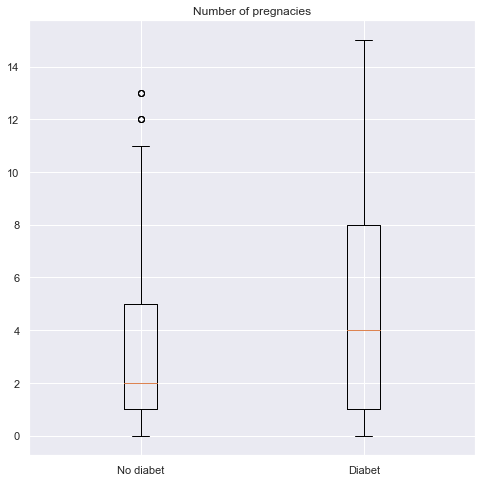

In [356]:
a = eda_train.loc[eda_train['Outcome'] == 0, 'Pregnancies']
b = eda_train.loc[eda_train['Outcome'] == 1, 'Pregnancies']

data = [a,b]

for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])

plt.xticks([0,1], ['No diabet','Diabet'])
plt.title ('Number of pregnacies')
plt.show()

### ML model

In [209]:
from pyspark.ml.feature import SQLTransformer

sqlTrans = SQLTransformer(
    statement = "SELECT age, BloodPressure as blood_pressure, outcome as label FROM __THIS__"
)

In [210]:
sqlTrans.transform(train).show(5)

+---+--------------+-----+
|age|blood_pressure|label|
+---+--------------+-----+
| 31|            88|    0|
| 22|            65|    0|
| 22|            64|    0|
| 38|            88|    1|
| 26|             0|    1|
+---+--------------+-----+
only showing top 5 rows



In [211]:
from pyspark.ml.feature import VectorAssembler


In [212]:
assembler = VectorAssembler(inputCols = ["age", "blood_pressure"], outputCol = "features", handleInvalid = 'keep')

In [213]:
df = assembler.transform(
    sqlTrans.transform(train)
).select("label", "features")

In [214]:
from pyspark.ml.classification import LogisticRegression

In [215]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)

In [216]:
lrModel = lr.fit(df)

In [217]:
print("Intercept: %s" % str(lrModel.intercept), "Coefficients: %s" % str(lrModel.coefficients))

Intercept: -2.077836911491793 Coefficients: [0.039930828810077916,0.000800677821348434]


In [218]:
trainingSummary = lrModel.summary

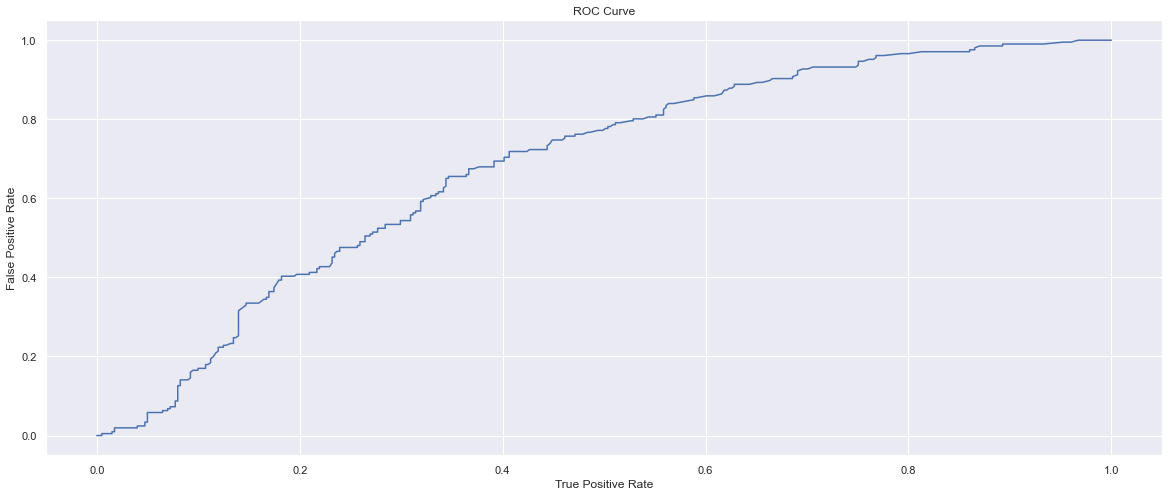

In [224]:
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


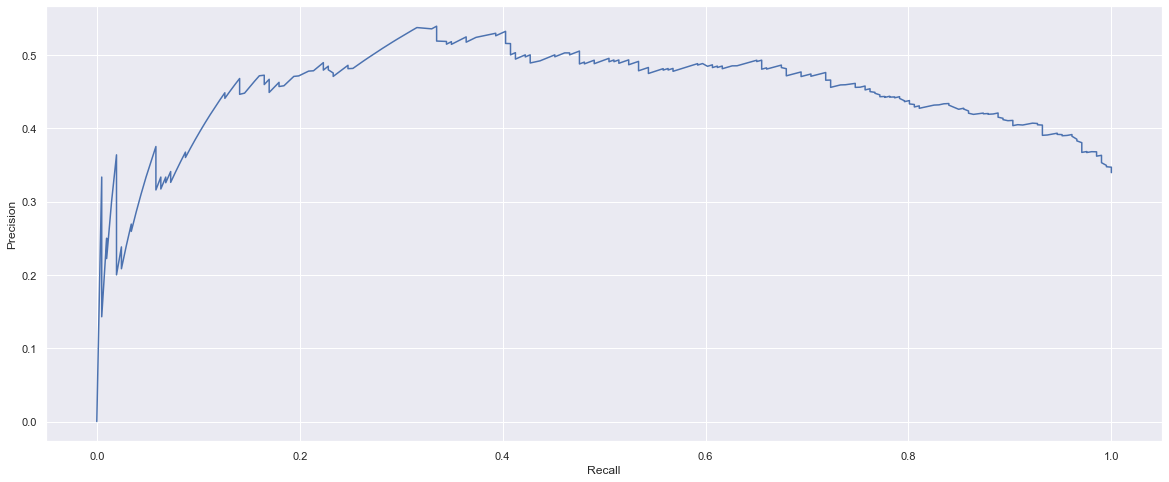

In [225]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [238]:
preds = lrModel.transform(
    assembler.transform(
        sqlTrans.transform(test)
    ).select("label", "features")
)

In [239]:
preds.show(5)

+-----+-----------+--------------------+--------------------+----------+
|label|   features|       rawPrediction|         probability|prediction|
+-----+-----------+--------------------+--------------------+----------+
|    1|[31.0,84.0]|[0.77272428138610...|[0.68410991565475...|       0.0|
|    0|[31.0,66.0]|[0.78713648217038...|[0.68721614731652...|       0.0|
|    0|[21.0,66.0]|[1.18644477027116...|[0.76610461132487...|       0.0|
|    0|[25.0,66.0]|[1.02672145503084...|[0.73627978798601...|       0.0|
|    0|[26.0,50.0]|[0.99960147136234...|[0.73098021592923...|       0.0|
+-----+-----------+--------------------+--------------------+----------+
only showing top 5 rows



In [240]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [241]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.elasticNetParam, [0]) \
    .build()

In [242]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [243]:
lr = LogisticRegression()
crossval = CrossValidator(estimator = lr,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

In [244]:
cvModel = crossval.fit(
    assembler.transform(
        sqlTrans.transform(train)
    ).select("label", "features")
)

In [245]:
list(zip(cvModel.avgMetrics, paramGrid))

[(0.688346592380668,
  {Param(parent='LogisticRegression_97eae2e7b4a0', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_97eae2e7b4a0', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LogisticRegression_97eae2e7b4a0', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}),
 (0.688346592380668,
  {Param(parent='LogisticRegression_97eae2e7b4a0', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_97eae2e7b4a0', name='fitIntercept', doc='whether to fit an intercept term.'): True,
   Param(parent='LogisticRegression_97eae2e7b4a0', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})]

In [246]:
print(cvModel.bestModel._java_obj.intercept(), cvModel.bestModel._java_obj.coefficients())

-2.077836911491793 [0.039930828810077916,8.00677821348434E-4]


In [247]:
preds = cvModel.transform(
    assembler.transform(
        sqlTrans.transform(test)
    ).select("label", "features")
)

In [248]:
BinaryClassificationEvaluator().evaluate(cvModel.transform(
    assembler.transform(
        sqlTrans.transform(test)
    ).select("label", "features")
))

0.6995764092538286

## Pipeline
### Model 1

In [301]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import PolynomialExpansion

sqlTrans = SQLTransformer(
    statement = "SELECT log(age) as age, BloodPressure, outcome as label FROM __THIS__"
)

assembler = VectorAssembler(inputCols = ["age", "BloodPressure"], outputCol = "features_for", handleInvalid = 'keep')

px = PolynomialExpansion(degree=2, inputCol="features_for", outputCol="features")

pipeline = Pipeline(stages = [sqlTrans, assembler, px, lr])

In [302]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.elasticNetParam, [0]) \
    .build()
crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

In [303]:
cvModel = crossval.fit(train)

In [305]:
cvModel.avgMetrics

[0.6825494180395824, 0.697281323877301]

/opt/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


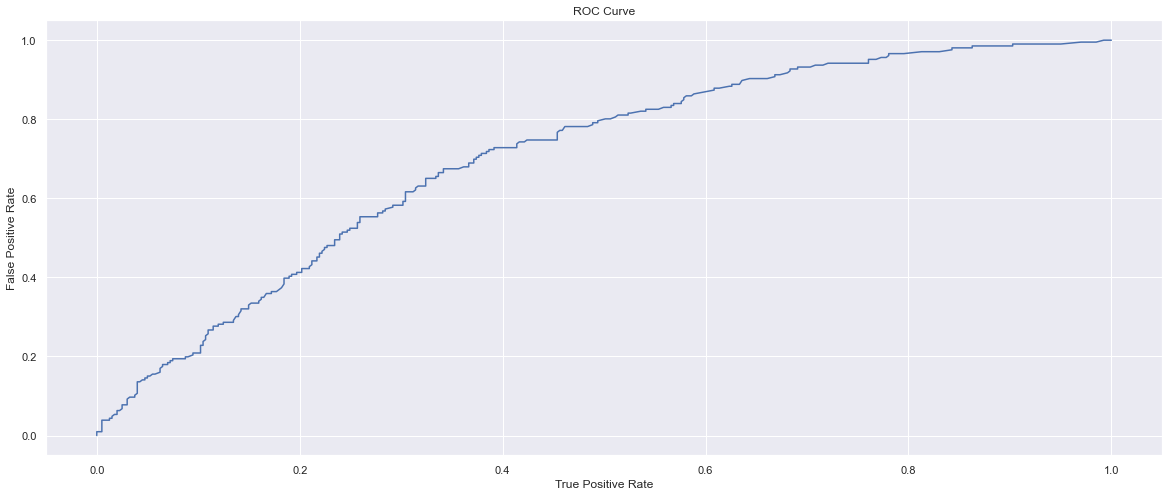

In [333]:
model_t= cvModel.bestModel.stages[3] 
trainingSummary = model_t.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


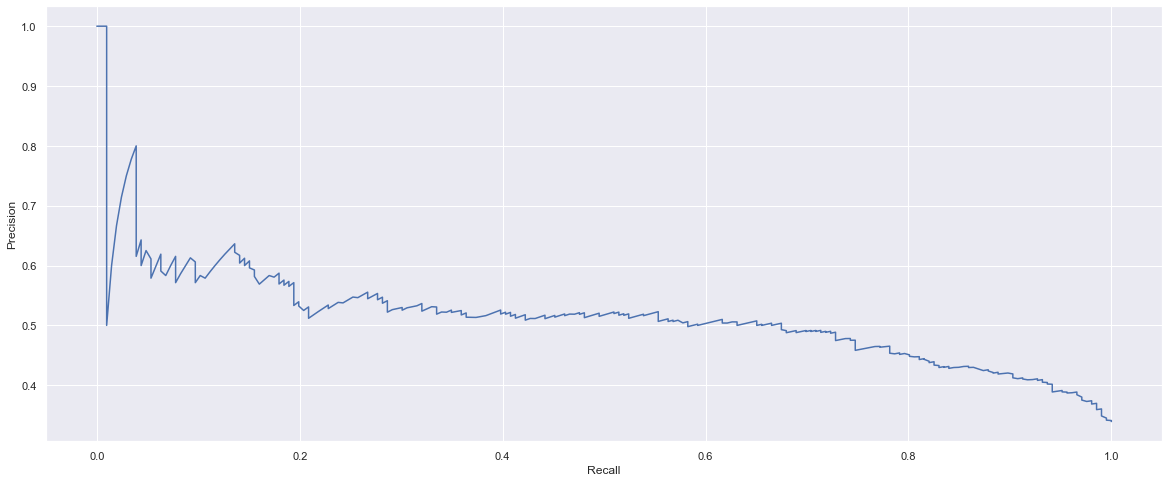

In [334]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [267]:
list(zip(cvModel.avgMetrics, paramGrid))

[(0.6936673299766006,
  {Param(parent='LogisticRegression_ab0e4165242d', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_ab0e4165242d', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LogisticRegression_ab0e4165242d', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}),
 (0.6988642862464403,
  {Param(parent='LogisticRegression_ab0e4165242d', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_ab0e4165242d', name='fitIntercept', doc='whether to fit an intercept term.'): True,
   Param(parent='LogisticRegression_ab0e4165242d', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})]

In [268]:
cvModel.transform(test).show(5)

+------------------+-------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|               age|BloodPressure|label|        features_for|            features|       rawPrediction|         probability|prediction|
+------------------+-------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|3.4339872044851463|           84|    1|[3.43398720448514...|[3.43398720448514...|[0.37582228426012...|[0.59286509484680...|       0.0|
|3.4339872044851463|           66|    0|[3.43398720448514...|[3.43398720448514...|[0.44265717079574...|[0.60889199890281...|       0.0|
| 3.044522437723423|           66|    0|[3.04452243772342...|[3.04452243772342...|[2.35128195779709...|[0.91303607046427...|       0.0|
|3.2188758248682006|           66|    0|[3.21887582486820...|[3.21887582486820...|[1.35364562916748...|[0.79472500487764...|       0.0|
| 3.258096538021482|           50|    0|[3.25809

In [270]:
test_error = RegressionEvaluator().evaluate(cvModel.transform(test))
print(test_error)

0.5737530362306164


### Model 2

In [280]:
qlTrans = SQLTransformer(
    statement = "SELECT Age, BloodPressure, \
    Pregnancies, Glucose, SkinThickness, \
    Insulin, DiabetesPedigreeFunction, \
    outcome as label FROM __THIS__"
)

assembler = VectorAssembler(inputCols = ["age", "BloodPressure"], outputCol = "features", handleInvalid = 'keep')

#px = PolynomialExpansion(degree=3, inputCol="features_for", outputCol="features")

pipeline = Pipeline(stages = [sqlTrans, assembler, lr])

In [281]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.elasticNetParam, [0]) \
    .build()
crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

In [282]:
cvModel = crossval.fit(train)

In [283]:
list(zip(cvModel.avgMetrics, paramGrid))

[(0.3505690989147326,
  {Param(parent='LogisticRegression_ab0e4165242d', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_ab0e4165242d', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LogisticRegression_ab0e4165242d', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}),
 (0.6880256676651726,
  {Param(parent='LogisticRegression_ab0e4165242d', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_ab0e4165242d', name='fitIntercept', doc='whether to fit an intercept term.'): True,
   Param(parent='LogisticRegression_ab0e4165242d', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})]

In [284]:
cvModel.transform(test).show(5)

+------------------+-------------+-----+--------------------+--------------------+--------------------+----------+
|               age|BloodPressure|label|            features|       rawPrediction|         probability|prediction|
+------------------+-------------+-----+--------------------+--------------------+--------------------+----------+
|3.4339872044851463|           84|    1|[3.43398720448514...|[0.74442205627847...|[0.67796208036933...|       0.0|
|3.4339872044851463|           66|    0|[3.43398720448514...|[0.73474416613584...|[0.67584548258256...|       0.0|
| 3.044522437723423|           66|    0|[3.04452243772342...|[1.41883922410936...|[0.80515637887052...|       0.0|
|3.2188758248682006|           66|    0|[3.21887582486820...|[1.11258741222297...|[0.75261117031205...|       0.0|
| 3.258096538021482|           50|    0|[3.25809653802148...|[1.03509364090048...|[0.73790221198285...|       0.0|
+------------------+-------------+-----+--------------------+-------------------

In [285]:
test_error = RegressionEvaluator().evaluate(cvModel.transform(test))
print(test_error)

0.6104676956673598
